# U-Net for Biomedical Image Segmentation

In [2]:
# Remember to mount google drive and change runtime as GPU
# Define the path as the directory for U-Net
# import os
path = "/content/drive/MyDrive/unet/"
# os.chdir(path)

## Data Augmentation
The original data is composed of 30 images obtained from the ISBI Challenge: Segmentation of neuronal structures in EM stacks. 25 images were adopted as the training data. The files and the original images and the corresponding labels before augmenting are shown by running the next two cells

In [3]:
import glob

train_path = path + "train/image/"
label_path = path + "train/label/"
images = sorted(glob.glob(train_path+"*png"))
labels = sorted(glob.glob(label_path+"*png"))
print("training images:")
print("\n".join(images[:3]))
print("...")
print("\n".join(images[-3:]))
print("\ntraining labels:")
print("\n".join(labels[:3]))
print("...")
print("\n".join(labels[-3:]))

training images:
/content/drive/MyDrive/unet/train/image/0.png
/content/drive/MyDrive/unet/train/image/1.png
/content/drive/MyDrive/unet/train/image/10.png
...
/content/drive/MyDrive/unet/train/image/7.png
/content/drive/MyDrive/unet/train/image/8.png
/content/drive/MyDrive/unet/train/image/9.png

training labels:
/content/drive/MyDrive/unet/train/label/0.png
/content/drive/MyDrive/unet/train/label/1.png
/content/drive/MyDrive/unet/train/label/10.png
...
/content/drive/MyDrive/unet/train/label/7.png
/content/drive/MyDrive/unet/train/label/8.png
/content/drive/MyDrive/unet/train/label/9.png


Example training images:


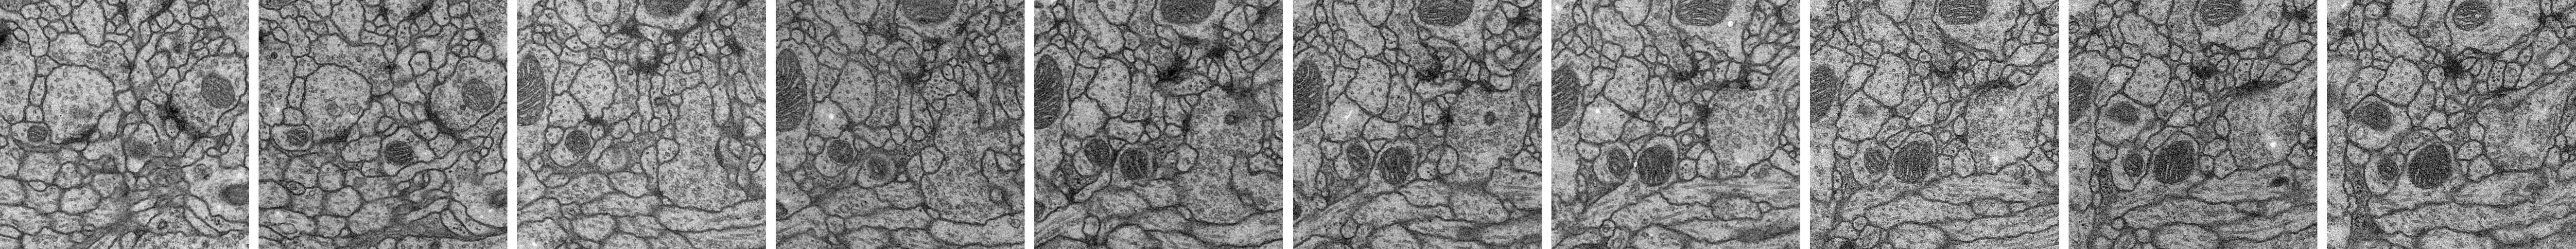

Corresponding labels:


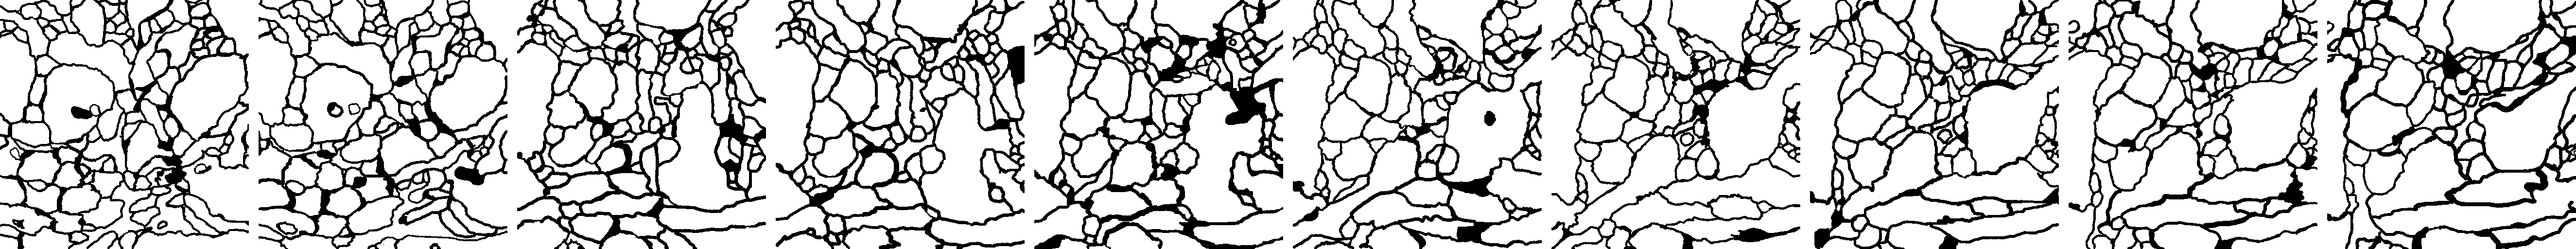

In [4]:
import PIL

def show_images_in_row(image_paths, interval_width=20):
    images = [PIL.Image.open(path) for path in image_paths]
    total_width = sum(img.width for img in images) + (len(images) - 1) * interval_width
    row_image = PIL.Image.new('L', (total_width, images[0].height), color=255)
    offset = 0
    for img in images:
        row_image.paste(img, (offset, 0))
        offset += img.width + interval_width
    row_image.show()

print("Example training images:")
show_images_in_row(images[:10])
print("Corresponding labels:")
show_images_in_row(labels[:10])

Data augmentation was performed for training data and test data. The 25 images of training data set was expanded to 275 images.

In [5]:
# Data augmentation

import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import math

gaussian = True
rotation_range=5
shear_range=0.1
zoom_range = 0.1
num_aug_per_img = 5

if not os.path.exists(path + "train/aug"):
    os.makedirs(path + "train/aug")
if not os.path.exists(path + "train/aug/image"):
    os.makedirs(path + "train/aug/image")
if not os.path.exists(path + "train/aug/label"):
    os.makedirs(path + "train/aug/label")
path_aug = path + "train/aug"

gaussian = 3
idx = 0
thresh = 200
imgs = glob.glob(train_path+"/*."+'png')

for i in range(len(imgs)):
    img_t = cv2.imread(train_path+"/"+str(i)+".png",0)
    img_l = cv2.imread(label_path+"/"+str(i)+".png",0)

    img_t = cv2.resize(img_t,(256,256),interpolation = cv2.INTER_AREA)
    img_l = cv2.resize(img_l,(256,256),interpolation = cv2.INTER_AREA)
    img_l = cv2.threshold(img_l , thresh, 255, cv2.THRESH_BINARY)[1]
    cv2.imwrite(path_aug+"/image/"+str(idx)+"-image.png",img_t)
    cv2.imwrite(path_aug+"/label/"+str(idx)+"-label.png",img_l)
    idx = idx+1
    for j in range(num_aug_per_img):
        img_t = cv2.imread(train_path+"/"+str(i)+".png",0)
        img_l = cv2.imread(label_path+"/"+str(i)+".png",0)

        theta = 2*rotation_range*random.random() - rotation_range
        theta = math.radians(theta)
        scale_x = 1 + (2*random.random()-1)* zoom_range
        scale_y = 1 + (2*random.random()-1)* zoom_range
        shear_x = (2*random.random()-1)*shear_range
        shear_y = (2*random.random()-1)*shear_range

        scale_matrix = np.array([[scale_x,0,0],[0,scale_y,0],[0,0,1]])
        shear_matrix = np.array([[1,shear_x,0],[shear_y,1,0],[0,0,1]])
        rotation_matrix = np.array([[math.cos(theta),-math.sin(theta),0],
                                    [math.sin(theta),math.cos(theta),0],
                                    [0,0,1]])
        affine_matrix = np.dot(scale_matrix,shear_matrix)
        affine_matrix = np.dot(affine_matrix,rotation_matrix)
        affine_matrix = affine_matrix[:2,:].astype(np.float32)

        img_t = img_t.astype(np.float32)
        img_t_warp = cv2.warpAffine(img_t, affine_matrix, img_t.shape)
        img_t_warp = img_t_warp.astype(np.uint8)
        img_t_warp = cv2.resize(img_t_warp,(256,256),interpolation = cv2.INTER_AREA)
        #img_t_warp = cv2.normalize(img_t_warp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        img_l_warp = cv2.warpAffine(img_l, affine_matrix, img_t.shape,borderValue=(255,255,255))
        img_l_warp = cv2.resize(img_l_warp,(256,256),interpolation = cv2.INTER_AREA)
        img_l_warp = cv2.threshold(img_l_warp , thresh, 255, cv2.THRESH_BINARY)[1]

        cv2.imwrite(path_aug+"/image/"+str(idx)+"-image.png",img_t_warp)
        cv2.imwrite(path_aug+"/label/"+str(idx)+"-label.png",img_l_warp)
        idx = idx+1

        if gaussian:
            # Generate Gaussian noise
            gauss = np.random.normal(-5,5,img_t.size)
            gauss = gauss.reshape(img_t.shape).astype(np.float64)
            # Add the Gaussian noise to the image
            img_gauss = img_t.astype(np.float64)
            img_gauss = cv2.add(img_gauss,gauss)
            img_gauss = cv2.resize(img_gauss,(256,256),interpolation = cv2.INTER_AREA)

            img_l = cv2.resize(img_l,(256,256),interpolation = cv2.INTER_AREA)
            img_l = cv2.threshold(img_l , thresh, 255, cv2.THRESH_BINARY)[1]

            cv2.imwrite(path_aug+"/image/"+str(idx)+"-image.png",img_gauss)
            cv2.imwrite(path_aug+"/label/"+str(idx)+"-label.png",img_l)
            idx = idx+1


Example augmented training images:


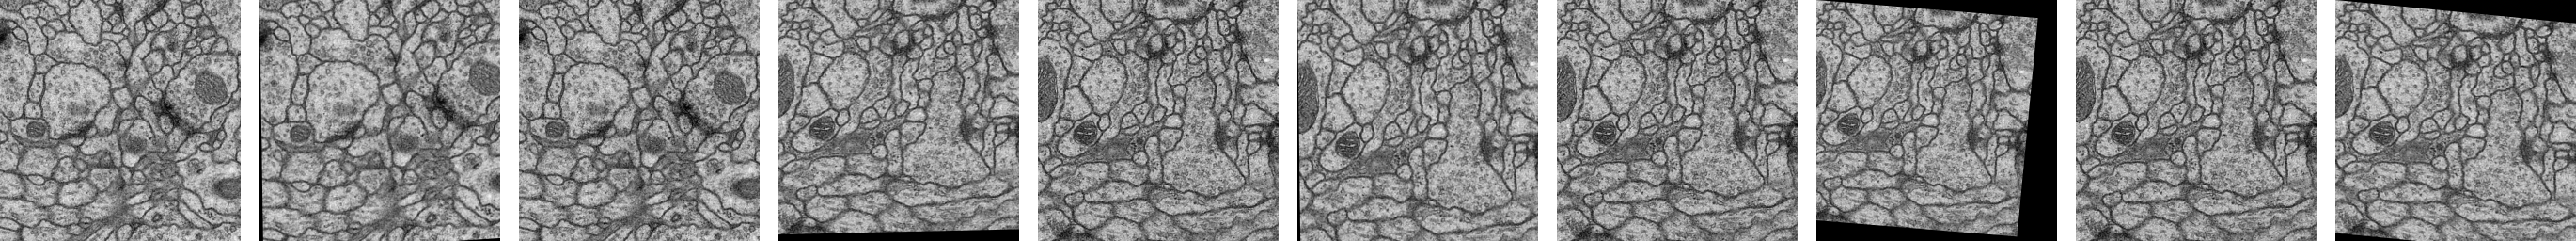

Corresponding labels:


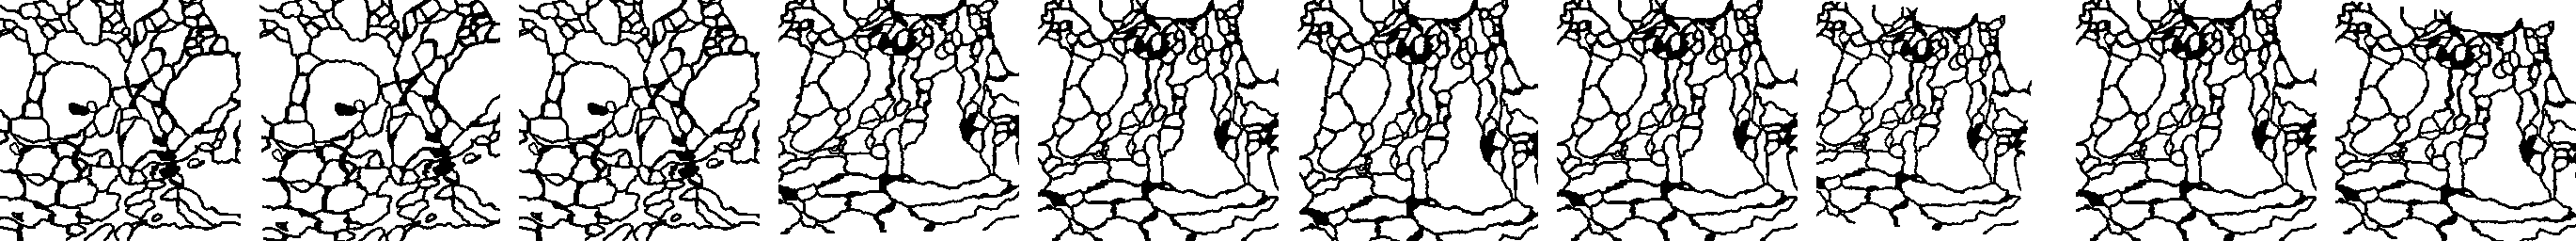

In [6]:
import PIL

def show_images_in_row(image_paths, interval_width=20):
    images = [PIL.Image.open(path) for path in image_paths]
    total_width = sum(img.width for img in images) + (len(images) - 1) * interval_width
    row_image = PIL.Image.new('L', (total_width, images[0].height), color=255)
    offset = 0
    for img in images:
        row_image.paste(img, (offset, 0))
        offset += img.width + interval_width
    row_image.show()

images = sorted(glob.glob(path_aug+"/image/*-image.png"))
labels = sorted(glob.glob(path_aug+"/label/*-label.png"))
# print(images)

print("Example augmented training images:")
show_images_in_row(images[:10])
print("Corresponding labels:")
show_images_in_row(labels[:10])

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 12 15:56:14 2021
"""
#place this file in the same directory that contains data folder

import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import math
gaussian = True
train_path = r'/content/drive/MyDrive/unet/test/no_aug/image'
label_path = r'/content/drive/MyDrive/unet/test/no_aug/label'
rotation_range=5
shear_range=0.1
zoom_range = 0.1
num_aug_per_img = 5


if not os.path.exists(path + "test/aug"):
    os.makedirs(path + "test/aug")
if not os.path.exists(path + "test/aug/image"):
    os.makedirs(path + "test/aug/image")
if not os.path.exists(path + "test/aug/label"):
    os.makedirs(path + "test/aug/label")
path_aug = path + "test/aug"
path_aug = r'/content/drive/MyDrive/unet/test/aug'
train_path = path + "test/image/"
label_path = path + "test/label/"

gaussian = 3
idx = 0
thresh = 200
imgs = glob.glob(train_path+"/*."+'png')
# print(imgs)
# print(imgs)
for i in range(len(imgs)):
    img_t = cv2.imread(train_path+"/"+str(i)+"-image.png",0)
    img_l = cv2.imread(label_path+"/"+str(i)+"-label.png",0)
    # print(img_t)
    img_t = cv2.resize(img_t,(256,256),interpolation = cv2.INTER_AREA)
    img_l = cv2.resize(img_l,(256,256),interpolation = cv2.INTER_AREA)
    img_l = cv2.threshold(img_l , thresh, 255, cv2.THRESH_BINARY)[1]
    cv2.imwrite(path_aug+"/image/"+str(idx)+"-image.png",img_t)
    cv2.imwrite(path_aug+"/label/"+str(idx)+"-label.png",img_l)
    idx = idx+1
    for j in range(num_aug_per_img):
        img_t = cv2.imread(train_path+"/"+str(i)+"-image.png",0)
        img_l = cv2.imread(label_path+"/"+str(i)+"-label.png",0)
        # print(img_t)
        theta = 2*rotation_range*random.random() - rotation_range
        theta = math.radians(theta)
        scale_x = 1 + (2*random.random()-1)* zoom_range
        scale_y = 1 + (2*random.random()-1)* zoom_range
        shear_x = (2*random.random()-1)*shear_range
        shear_y = (2*random.random()-1)*shear_range

        scale_matrix = np.array([[scale_x,0,0],[0,scale_y,0],[0,0,1]])
        shear_matrix = np.array([[1,shear_x,0],[shear_y,1,0],[0,0,1]])
        rotation_matrix = np.array([[math.cos(theta),-math.sin(theta),0],
                                    [math.sin(theta),math.cos(theta),0],
                                    [0,0,1]])
        affine_matrix = np.dot(scale_matrix,shear_matrix)
        affine_matrix = np.dot(affine_matrix,rotation_matrix)
        affine_matrix = affine_matrix[:2,:].astype(np.float32)
        # print(img_t)
        img_t = img_t.astype(np.float32)
        img_t_warp = cv2.warpAffine(img_t, affine_matrix, img_t.shape)
        img_t_warp = img_t_warp.astype(np.uint8)
        img_t_warp = cv2.resize(img_t_warp,(256,256),interpolation = cv2.INTER_AREA)
        #img_t_warp = cv2.normalize(img_t_warp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        img_l_warp = cv2.warpAffine(img_l, affine_matrix, img_t.shape,borderValue=(255,255,255))
        img_l_warp = cv2.resize(img_l_warp,(256,256),interpolation = cv2.INTER_AREA)




        img_l_warp = cv2.threshold(img_l_warp , thresh, 255, cv2.THRESH_BINARY)[1]

        cv2.imwrite(path_aug+"/image/"+str(idx)+"-image.png",img_t_warp)
        cv2.imwrite(path_aug+"/label/"+str(idx)+"-label.png",img_l_warp)
        idx = idx+1

        if gaussian:
            # Generate Gaussian noise
            gauss = np.random.normal(-5,5,img_t.size)
            gauss = gauss.reshape(img_t.shape).astype(np.float64)
            # Add the Gaussian noise to the image
            img_gauss = img_t.astype(np.float64)
            img_gauss = cv2.add(img_gauss,gauss)
            img_gauss = cv2.resize(img_gauss,(256,256),interpolation = cv2.INTER_AREA)

            img_l = cv2.resize(img_l,(256,256),interpolation = cv2.INTER_AREA)
            img_l = cv2.threshold(img_l , thresh, 255, cv2.THRESH_BINARY)[1]

            cv2.imwrite(path_aug+"/image/"+str(idx)+"-image.png",img_gauss)
            cv2.imwrite(path_aug+"/label/"+str(idx)+"-label.png",img_l)
            idx = idx+1


In [8]:
# print(train_path)
# print(path_aug)
# im = glob.glob(path_aug+"/image/*.png")
# print(path_aug+"/image/")
# print(im)
# print(len(im))

## Running the model with the augmented data

In [9]:
# Prepare training and test data after augmentation
import glob

images = sorted(glob.glob(path + "/train/aug/image/*.png"))
images_mask = sorted(glob.glob(path + "/train/aug/label/*.png"))
images_test_aug = sorted(glob.glob(path + "/test/aug/image/*.png"))

print("Training set images:")
print("\n".join(images[:3]))
print("...")
print("\n".join(images[-3:]))

print("\nTraining set labels:")
print("\n".join(images_mask[:3]))
print("...")
print("\n".join(images_mask[-3:]))

print("\nTest set:")
print("\n".join(images_test_aug[:3]))
print("...")
print("\n".join(images_test_aug[-3:]))

Training set images:
/content/drive/MyDrive/unet//train/aug/image/0-image.png
/content/drive/MyDrive/unet//train/aug/image/1-image.png
/content/drive/MyDrive/unet//train/aug/image/10-image.png
...
/content/drive/MyDrive/unet//train/aug/image/97-image.png
/content/drive/MyDrive/unet//train/aug/image/98-image.png
/content/drive/MyDrive/unet//train/aug/image/99-image.png

Training set labels:
/content/drive/MyDrive/unet//train/aug/label/0-label.png
/content/drive/MyDrive/unet//train/aug/label/1-label.png
/content/drive/MyDrive/unet//train/aug/label/10-label.png
...
/content/drive/MyDrive/unet//train/aug/label/97-label.png
/content/drive/MyDrive/unet//train/aug/label/98-label.png
/content/drive/MyDrive/unet//train/aug/label/99-label.png

Test set:
/content/drive/MyDrive/unet//test/aug/image/0-image.png
/content/drive/MyDrive/unet//test/aug/image/1-image.png
/content/drive/MyDrive/unet//test/aug/image/10-image.png
...
/content/drive/MyDrive/unet//test/aug/image/7-image.png
/content/drive/My

In [10]:
#load training data and test data

import cv2
import numpy as np

X_train = []
for image in images:
    X_train.append(cv2.imread(image, 0)) # Use cv2 imread to convert image files to numpy arrays
X_train = np.array(X_train, dtype=np.float32)
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
X_train /= 255

y_train = []
for image in images_mask:
    y_train.append(cv2.imread(image, 0)) # Use cv2 imread to convert image files to numpy arrays
y_train = np.array(y_train, dtype=np.float32)
y_train = y_train.reshape(y_train.shape[0], 256, 256, 1)
y_train /= 255

# duplicate training data
# change to smaller repeat number if break RAM limit
X_train = X_train.repeat(10,axis=0)
y_train = y_train.repeat(10,axis=0)

#load test data
x_test = []
for fl in images_test_aug:
    x_test.append(cv2.imread(image, 0)) # Use cv2 imread to convert image files to numpy arrays
x_test = np.array(x_test, dtype=np.float32)
x_test = x_test.reshape(x_test.shape[0], 256, 256, 1)
x_test /= 255

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)


X_train shape: (2750, 256, 256, 1)
y_train shape: (2750, 256, 256, 1)
X_test shape: (55, 256, 256, 1)


In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from keras.optimizers import Adam

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)


    model = Model(inputs,  conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    # model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

In [12]:
import random
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

seed_value = 1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane_BN.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(X_train,y_train,epochs=10,steps_per_epoch=1000,callbacks=[model_checkpoint])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.3570 - accuracy: 0.8384
Epoch 1: loss improved from inf to 0.35696, saving model to unet_membrane_BN.hdf5
1000/1000 [==============================] - 263s 250ms/step - loss: 0.3570 - accuracy: 0.8384
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9205
Epoch 2: loss improved from 0.35696 to 0.19001, saving model to unet_membrane_BN.hdf5
1000/1000 [==============================] - 253s 253ms/step - loss: 0.1900 - accuracy: 0.9205
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9428
Epoch 3: loss improved from 0.19001 to 0.13789, saving model to unet_membrane_BN.hdf5
1000/1000 [==============================] - 253s 253ms/step - loss: 0.1379 - accuracy: 0.9428
Epoch 4/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9541
Epoch 4: loss improved from 0.13789 to 0.11092, saving model to unet_


Epoch 10: loss improved from 0.05719 to 0.05513, saving model to unet_membrane_BN.hdf5
1000/1000 [==============================] - 43s 43ms/step - loss: 0.0551 - accuracy: 0.9777


In [13]:
from keras.models import load_model
model = load_model('unet_membrane_BN.hdf5')

In [16]:
import skimage

def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    thres = 200
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        img = cv2.threshold(img , 200/255, 255, cv2.THRESH_BINARY)[1]
        skimage.io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

results = model.predict(x_test)

#results_class = results.argmax(axis=-1)
saveResult(path + "test/aug/pred",results)

2/2 [==============================] - 1s 669ms/step
